# Train and evaluate Explainers

With all these prerequisites out of the way you can now run the experiments themselves. The experiments are run for each
explanation method (T-GNNExplainer, GreDyCF, CoDy), for each dataset, for each correct/incorrect setting 
(correct predictions only/incorrect predictions only), and for each selection policy (random, temporal, spatio-temporal, 
local-gradient) separately. For convenience, all selection strategies can be automatically evaluated in parallel from a 
single script. An additional feature of the evaluation is that it can be interrupted by Keyboard Interruption or by the
maximum processing time. When the evaluation is interrupted before it is finished, the intermediary results are saved. 
The evaluation automatically resumes from intermediary results.

In [1]:
# Find and add `notebooks/src` to sys.path, no matter where the notebook lives.
from pathlib import Path
import json
import sys, importlib
import os, re
import torch
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path.cwd().resolve()
root_candidate = ROOT if (ROOT / "time_to_explain").exists() else ROOT.parent
if (root_candidate / "time_to_explain").exists():
    sys.path.insert(0, str(root_candidate))


from time_to_explain.utils.constants import (
    REPO_ROOT, PKG_DIR, RESOURCES_DIR, PROCESSED_DATA_DIR, MODELS_ROOT, TGN_SUBMODULE_ROOT, ensure_repo_importable, get_last_checkpoint,
    load_notebook_config,
)
from time_to_explain.utils.device import pick_device
NOTEBOOK_CFG = load_notebook_config()
SEED = int(NOTEBOOK_CFG.get("seed", 42))
DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto"))
print(f"Notebook config: seed={SEED}, device={DEVICE}")
DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto") if "NOTEBOOK_CFG" in globals() else "auto")
print("Using device:", DEVICE)
for p in (str(TGN_SUBMODULE_ROOT), str(REPO_ROOT), str(PKG_DIR)):
    if p not in sys.path:
        sys.path.insert(0, p)

if "utils" in sys.modules:
    del sys.modules["utils"]

importlib.invalidate_caches()

print("REPO_ROOT        :", REPO_ROOT)
print("PKG_DIR          :", PKG_DIR)
print("RESOURCES_DIR    :", RESOURCES_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODELS_ROOT      :", MODELS_ROOT)


Notebook config: seed=42, device=mps
Using device: mps
REPO_ROOT        : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
PKG_DIR          : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain
RESOURCES_DIR    : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources
PROCESSED_DATA_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/datasets/processed
MODELS_ROOT      : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models


## Imports

In [2]:
from time_to_explain.utils.utils_loader import _resolve_checkpoint
# Core imports
from time_to_explain.data import load_explain_idx

from time_to_explain.models import load_backbone_model
from time_to_explain.core.runner import EvaluationRunner, EvalConfig
from time_to_explain.visualization import plot_selected_metrics

from time_to_explain.explainer.tempme import TempMEAdapter as SimpleTempMEAdapter, TempMEAdapterConfig as SimpleTempMEAdapterConfig
from time_to_explain.extractors.base_extractor import BaseExtractor
from time_to_explain.extractors.khop_extractor import KHopCandidatesExtractor
from time_to_explain.visualization import filter_explainers, prepare_metrics_plotting


## Config

In [3]:
MODEL_TYPE = "tgn"
MODEL_WEIGHTS ="/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/explainer/TemGX/link/resources/models/wikipedia/TGN-wikipedia.pth"  # or path to a .pth checkpoint
DATASET_NAME = "wikipedia"
TIME_LIMIT = 240

N = 1
USE_CACHED_RESULTS = False
RECOMPUTE_METRICS = False


## Load Dataset and Model

In [4]:
ckpt_path = _resolve_checkpoint(MODELS_ROOT, DATASET_NAME, MODEL_TYPE, MODEL_WEIGHTS)
print("Using checkpoint:", ckpt_path)
explain_idx_csv = str(RESOURCES_DIR / "explainer" / "explain_index" / f"{DATASET_NAME}.csv")
print("Explain index CSV:", explain_idx_csv)
from time_to_explain.data import load_processed_dataset

edge_path = PROCESSED_DATA_DIR / f"ml_{DATASET_NAME}.npy"
if not edge_path.exists():
    bundle = load_processed_dataset(DATASET_NAME)
    if bundle.get("edge_features") is None:
        node_feats = bundle.get("node_features")
        if node_feats is None:
            raise ValueError(f"Missing node_features for {DATASET_NAME}.")
        df = bundle["interactions"]
        edge_feats = np.zeros((len(df) + 1, node_feats.shape[1]), dtype=node_feats.dtype)
        edge_feats[1:] = node_feats[df["u"].to_numpy(dtype=int)] + node_feats[df["i"].to_numpy(dtype=int)]
        np.save(edge_path, edge_feats)
        print(f"Created edge features at {edge_path} with shape {edge_feats.shape}")
from shutil import copy2
from time_to_explain.data.tempme_preprocess import TempMEPreprocessConfig, prepare_tempme_dataset

TEMP_ME_PROCESSED_DIR = REPO_ROOT / "submodules" / "explainer" / "tempme" / "processed"
TEMP_ME_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

for name in (
    f"ml_{DATASET_NAME}.csv",
    f"ml_{DATASET_NAME}.npy",
    f"ml_{DATASET_NAME}_node.npy",
):
    src = PROCESSED_DATA_DIR / name
    dst = TEMP_ME_PROCESSED_DIR / name
    if src.exists() and not dst.exists():
        copy2(src, dst)

_tempme_required = [
    TEMP_ME_PROCESSED_DIR / f"{DATASET_NAME}_train_cat.h5",
    TEMP_ME_PROCESSED_DIR / f"{DATASET_NAME}_test_cat.h5",
    TEMP_ME_PROCESSED_DIR / f"{DATASET_NAME}_train_edge.npy",
    TEMP_ME_PROCESSED_DIR / f"{DATASET_NAME}_test_edge.npy",
]
if not all(p.exists() for p in _tempme_required):
    tempme_cfg = TempMEPreprocessConfig(
        dataset_name=DATASET_NAME,
        processed_dir=PROCESSED_DATA_DIR,
        output_dir=TEMP_ME_PROCESSED_DIR,
        overwrite=False,
        validate_existing=False,
    )
    _ = prepare_tempme_dataset(tempme_cfg)


Using checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/explainer/TemGX/link/resources/models/wikipedia/TGN-wikipedia.pth
Explain index CSV: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/explain_index/wikipedia.csv


In [5]:
model, events = load_backbone_model(
    model_type=MODEL_TYPE,
    dataset_name=DATASET_NAME,
    ckpt_path=ckpt_path,
    device=DEVICE,
)

## Build Extractor and Explainer

### Build Extractor

In [6]:
# Extractors: main for mask-based explainers (reused for TempME so fidelity masks align)
extractor_main = BaseExtractor(
    model=model,
    events=events,
    threshold_num=5000,
    keep_order="last-N-then-sort",
)

khop_ext  = KHopCandidatesExtractor(model=model, events=events, candidates_size=75)

<hr style="height:1px;border:none;background:#ccc;">


### Build Explainer

In [7]:
from time_to_explain.explainer.loader import make_explainer_builder
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.method.tg_score import _set_tgat_data
import torch
from time_to_explain.core.types import Subgraph

def shap_score_fn(model, dataset, target_event_idx, active_event_ids):
    events_df = dataset.get("events") if isinstance(dataset, dict) else dataset
    src_idx_l, target_idx_l, cut_time_l = _set_tgat_data(events_df, target_event_idx)
    preserve = list(active_event_ids) if active_event_ids else None
    out = model.get_prob(src_idx_l, target_idx_l, cut_time_l, logit=True, edge_idx_preserve_list=preserve)
    return float(out.detach().cpu().item()) if hasattr(out, "detach") else float(out)

def grad_forward_fn(model, dataset, target_event_idx, candidate_eidx, mask):
    subgraph = Subgraph(
        node_ids=[],
        edge_index=[],
        payload={"candidate_eidx": list(candidate_eidx), "event_idx": int(target_event_idx)},
    )
    score = model.predict_proba_with_mask(
        subgraph,
        {"event_idx": int(target_event_idx)},
        edge_mask=mask,
    )
    if isinstance(score, torch.Tensor):
        return score.squeeze()
    return torch.as_tensor(score, device=mask.device, dtype=mask.dtype).squeeze()

build_explainer = make_explainer_builder(
    dataset_name=DATASET_NAME,
    model_type=MODEL_TYPE,
    device=DEVICE,
    seed=SEED,
    callable_scope=globals(),
)

def _build_tempme():
    cfg = SimpleTempMEAdapterConfig(
        model_name=str(MODEL_TYPE).lower(),
        dataset_name=str(DATASET_NAME).lower(),
        score_fn=shap_score_fn,
        device=DEVICE,
    )
    return SimpleTempMEAdapter(cfg)

EXPLAINER_NAMES = [
    "tgnnexplainer",
    "tempme",
    "pg",
    "temgx",
    #"gnn",
    "perturb_one",
    "shap",
    "grad",
    "attn",
    #"cody",
    "greedy",
    "cody_tgn_impl",
    "random",
    "degree",
]
RUN_EXPLAINERS = None  # subset of EXPLAINER_NAMES

EXPLAINER_BUILDERS = {
    "tgnnexplainer": lambda: build_explainer("tgnnexplainer"),
    "tempme": _build_tempme,
    "pg": lambda: build_explainer("pg"),
    "temgx": lambda: build_explainer("temgx"),
    "gnn": lambda: build_explainer("gnn"),
    "perturb_one": lambda: build_explainer("perturb_one"),
    "shap": lambda: build_explainer("shap"),
    "grad": lambda: build_explainer("grad"),
    "attn": lambda: build_explainer("attn"),
    "cody": lambda: build_explainer("cody"),
    "greedy": lambda: build_explainer("greedy"),
    "cody_tgn_impl": lambda: build_explainer("cody_tgn_impl"),
    "random": lambda: build_explainer("random"),
    "degree": lambda: build_explainer("degree"),
}

def _build_explainers(names):
    explainers = []
    for name in names:
        builder = EXPLAINER_BUILDERS.get(name)
        if builder is None:
            print(f"Unknown explainer: {name}")
            continue
        explainer = builder()
        if explainer is None:
            continue
        explainers.append(explainer)
    return explainers

active_explainers = RUN_EXPLAINERS or EXPLAINER_NAMES
EXPLAINERS = _build_explainers(active_explainers)
print("Explainers configured:", [e.alias for e in EXPLAINERS])


Built explainer 'tgnnexplainer' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/tgnnexplainer.json
Built explainer 'pg' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/pg.json
Built explainer 'temgx' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/temgx.json
Built explainer 'perturb_one' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/perturb_one.json
Built explainer 'shap' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/shap.json
Built explainer 'grad' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/grad.json
Built explainer 'attn' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/attn.json
Built explainer 'greedy' from /Users/juliawenk

<hr style="height:1px;border:none;background:#ccc;">


### Define Metrics

In [8]:
METRICS_CFG = json.loads((REPO_ROOT / "configs" / "metrics" / "default.json").read_text())
target_event_idxs = load_explain_idx(explain_idx_csv, start=0)
anchors = [{"target_kind": "edge", "event_idx": int(e)} for e in target_event_idxs[:N]]
METRICS_CFG = dict(METRICS_CFG)

cfg = EvalConfig(
    out_dir="runs",
    metrics=METRICS_CFG,
    seed=SEED,
    resume=USE_CACHED_RESULTS
)

100 events to explain


## Run Evaluation

In [9]:
runner = EvaluationRunner(
    model=model,
    dataset={"events": events, "dataset_name": DATASET_NAME},
    extractor=khop_ext,
    explainers=EXPLAINERS,
    config=cfg
)

In [10]:
explainer_aliases = "-".join(e.alias for e in EXPLAINERS)
run_id = f"{DATASET_NAME}_{MODEL_TYPE}_{explainer_aliases}"

if not USE_CACHED_RESULTS:
    out = runner.run(
        anchors,
        k_hop=getattr(model, "num_layers", 5) or 5,
        num_neighbors=getattr(model, "num_neighbors", 20) or 20,
        run_id=run_id,
    )
    print(f"Stored new explanations under {out['out_dir']}")

explainer ckpt loaded from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/tgnnexplainer/tgn_wikipedia_tgnnexplainer_expl_ckpt.pt
explainer ckpt loaded from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/pg_explainer/tgn_wikipedia_pg_expl_ckpt.pt

[EvaluationRunner] Anchor 1/1 (target=110314)
[EvaluationRunner]   [1/12] tgnnexplainer: start

explain 0-th: 110314
The nodes in graph is 146


mcts simulating: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s, states=3292]


mcts recorder saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/tgnnexplainer/candidate_scores/tgn_wikipedia_110314_mcts_recorder_mlp_true_pg_positive_th20.csv
results saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/tgnnexplainer/mcts_saved_dir/tgn_wikipedia_110314_mcts_node_info_mlp_true_pg_positive_th20.pt
[EvaluationRunner]   [1/12] tgnnexplainer: done in 101.15s
n_importance: 74
n_candidate: 74
[Runner debug] explainer=tgnnexplainer candidates=74
[EvaluationRunner]   [2/12] tempme: start
[EvaluationRunner]   [2/12] tempme: done in 0.77s
n_importance: 74
n_candidate: 74
[Runner debug] explainer=tempme candidates=74
[EvaluationRunner]   [3/12] pg: start

explain 0-th: 110314
candidate scores saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgn_wikipedia_pg_110314_candidate_scores_th50.csv
[EvaluationRunner] 

## Inspect Results and Metrics

In [11]:
# Optional: load an existing run for visualization
from pathlib import Path

runs_dir = Path(getattr(globals().get("cfg", None), "out_dir", "runs"))
if runs_dir.is_absolute():
    RUNS_ROOTS = [runs_dir]
else:
    RUNS_ROOTS = [
        REPO_ROOT / runs_dir,
        REPO_ROOT / "notebooks" / runs_dir,
    ]

SELECT_RUN_ID = None  # set manually to load a past run
SELECT_RUN_PATH = None  # optional: full path to a run directory
if "out" in globals() and isinstance(out, dict) and out.get("out_dir"):
    SELECT_RUN_PATH = out["out_dir"]
USE_SELECTED_RUN = False

if SELECT_RUN_ID or SELECT_RUN_PATH:
    if SELECT_RUN_PATH:
        run_dir = Path(SELECT_RUN_PATH).expanduser()
    else:
        run_dir = None
        for root in RUNS_ROOTS:
            candidate = root / str(SELECT_RUN_ID)
            if candidate.exists():
                run_dir = candidate
                break
        if run_dir is None:
            raise FileNotFoundError(f"Run '{SELECT_RUN_ID}' not found under {RUNS_ROOTS}.")

    metrics_path = run_dir / "metrics.csv"
    if not metrics_path.exists():
        raise FileNotFoundError(f"Missing metrics.csv in {run_dir}")
    results_path = run_dir / "results.jsonl"

    out = {
        "out_dir": str(run_dir),
        "csv": str(metrics_path),
        "jsonl": str(results_path) if results_path.exists() else None,
    }
    USE_SELECTED_RUN = True
    print(f"Loaded run from {run_dir}")


Loaded run from runs/wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-perturb_one-shap-grad-attn-greedy-cody_tgn_impl-random-degree


In [12]:
if globals().get("RECOMPUTE_METRICS", False):
    if "runner" not in globals():
        raise RuntimeError("runner is not defined; cannot recompute metrics.")
    if not isinstance(out, dict) or not out.get("jsonl"):
        raise FileNotFoundError("Missing results.jsonl; cannot recompute metrics.")
    out = runner.compute_metrics_from_results(out["jsonl"], resume=False)
    print(f"Recomputed metrics at {out['csv']}")

metrics_path = out["csv"]
metrics_df = pd.read_csv(metrics_path)
print(f"Loaded metrics from {metrics_path}")
print(f"Rows: {len(metrics_df)}, Columns: {len(metrics_df.columns)}")

VIS_EXPLAINERS =  None #["cody", "temgx", "tgnnexplainer"]
if VIS_EXPLAINERS:
    metrics_df = filter_explainers(metrics_df, include=VIS_EXPLAINERS)

use_selected_run = globals().get("USE_SELECTED_RUN", False)
explainer_order = None
if "EXPLAINERS" in globals():
    explainer_order = [e.alias for e in EXPLAINERS]
if use_selected_run:
    explainer_order = [str(x) for x in pd.unique(metrics_df["explainer"]) ]
if VIS_EXPLAINERS:
    if explainer_order:
        explainer_order = [e for e in explainer_order if e in VIS_EXPLAINERS]
    else:
        explainer_order = list(VIS_EXPLAINERS)
metrics_df, palette = prepare_metrics_plotting(
    metrics_df, explainer_order=explainer_order
)

context_cols = [c for c in ("anchor_idx", "explainer", "run_id", "elapsed_sec") if c in metrics_df.columns]


DEFAULT_METRICS_TO_PLOT = [
    "fidelity_minus.value",
    "fidelity_plus.value",
    "sparsity.ratio",
    "aufsc.value",
    "elapsed_sec",
]

extra_metric_cols = [
    c for c in metrics_df.columns
    if c not in context_cols
    and c not in DEFAULT_METRICS_TO_PLOT
    and pd.api.types.is_numeric_dtype(metrics_df[c])
    and "prediction_" not in c
    and ".prediction" not in c
    and "@" not in c
]

METRICS_TO_PLOT = DEFAULT_METRICS_TO_PLOT + extra_metric_cols
print("Metrics to plot:", METRICS_TO_PLOT)



Loaded metrics from runs/wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-perturb_one-shap-grad-attn-greedy-cody_tgn_impl-random-degree/metrics.csv
Rows: 12, Columns: 19
Metrics to plot: ['fidelity_minus.value', 'fidelity_plus.value', 'sparsity.ratio', 'aufsc.value', 'elapsed_sec']


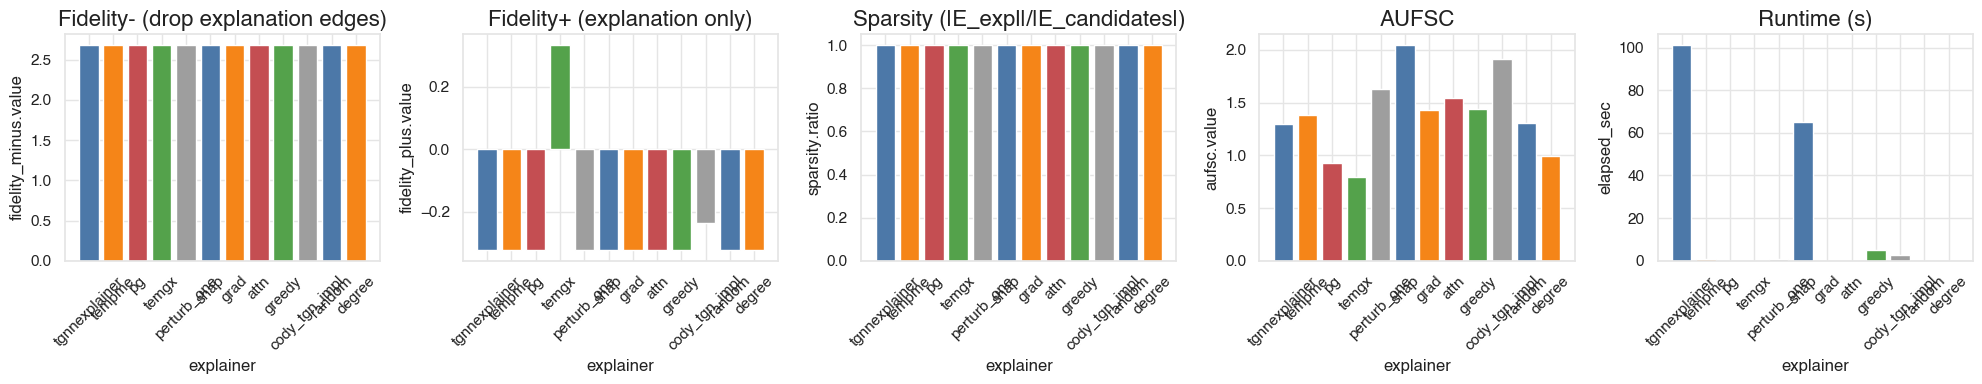

,run_id,anchor_idx,context_fp,explainer,elapsed_sec,sparsity.ratio,fidelity_minus.value,fidelity_minus.@s=0,fidelity_minus.@s=0.25,fidelity_minus.@s=0.5,fidelity_minus.@s=0.75,fidelity_minus.@s=1,fidelity_plus.value,fidelity_plus.@s=0,fidelity_plus.@s=0.25,fidelity_plus.@s=0.5,fidelity_plus.@s=0.75,fidelity_plus.@s=1,aufsc.value
0,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,tgnnexplainer,101.145236,1.0,2.682014,1.324284,1.066257,1.066257,2.581695,2.682014,-0.324284,-1.682014,0.415522,0.415522,-0.659364,-0.324284,1.297460
1,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,tempme,0.765791,1.0,2.682014,1.324284,1.570170,1.576717,0.578983,2.682014,-0.324284,-1.682014,0.609634,-0.009122,0.605903,-0.324284,1.382221
2,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,pg,0.047214,1.0,2.682014,1.324284,0.500058,0.500058,0.500058,2.682014,-0.324284,-1.682014,0.552930,0.552930,0.552930,-0.324284,0.928228
3,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,temgx,0.095450,1.0,2.682014,2.682014,2.682014,2.682014,2.682014,2.682014,0.334064,0.334064,0.334064,0.334064,0.334064,0.334064,0.795973
4,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,perturb_one,0.683542,1.0,2.682014,1.324284,1.949179,1.949179,2.020795,2.682014,-0.324284,-1.682014,0.020225,0.020225,0.020225,-0.324284,1.631493
5,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,shap,64.924331,1.0,2.682014,1.324284,2.816935,2.874744,2.662094,2.682014,-0.324284,-1.682014,-0.604408,-0.604408,-0.325203,-0.324284,2.044004
6,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,grad,0.108602,1.0,2.682014,1.324284,1.324284,2.290152,0.713782,2.682014,-0.324284,-1.682014,-1.682014,-0.187835,0.515813,-0.324284,1.428697
7,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,attn,0.055755,1.0,2.682014,1.324284,1.081808,2.682014,2.682014,2.682014,-0.324284,-1.682014,-0.083538,-0.324284,-0.324284,-0.324284,1.545305
8,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,greedy,5.084056,1.0,2.682014,1.324284,1.326176,2.292475,0.840005,2.682014,-0.324284,-1.682014,-1.682014,-0.187835,0.879071,-0.324284,1.437567
9,wikipedia_tgn_tgnnexplainer-tempme-pg-temgx-pe...,0,ae37357899aa81a0df7dbc0e821c65f5d9e284b6,cody_tgn_impl,2.754570,1.0,2.682014,1.237264,2.642660,2.642660,2.642660,2.682014,-0.237264,-1.682014,0.334064,0.334064,0.334064,-0.237264,1.916344


In [13]:
_ = plot_selected_metrics(
    metrics_df,
    METRICS_TO_PLOT,
    palette=palette,
    group_col="explainer",
)

metrics_df

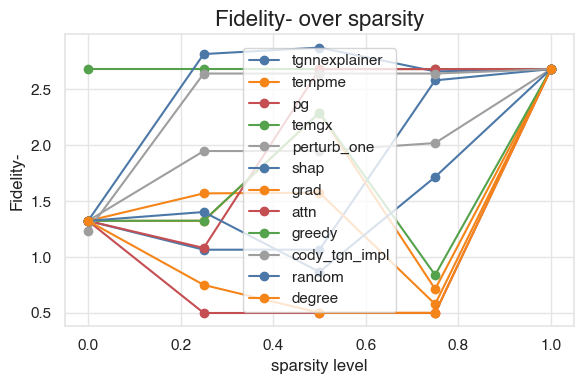

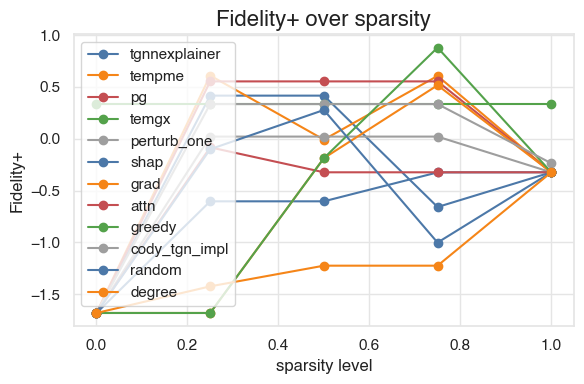

In [14]:
# Fidelity over sparsity curves (requires per-sparsity metric outputs)
import re

FIDELITY_LABELS = {
    "fidelity_minus": "Fidelity-",
    "fidelity_plus": "Fidelity+",
    "fidelity_drop": "Fidelity- (drop)",
    "fidelity_keep": "Fidelity+ (keep)",
    "fidelity_tempme": "Fidelity (TempME)",
    "temgx_fidelity_minus": "TemGX Fidelity-",
    "temgx_fidelity_plus": "TemGX Fidelity+",
}

def _collect_fidelity_sparsity_cols(df):
    pattern = re.compile(r"^(?P<metric>[^.]*fidelity[^.]*)\.(?P<key>@s=.+)$")
    out = {}
    for col in df.columns:
        m = pattern.match(col)
        if not m:
            continue
        metric = m.group("metric")
        key = m.group("key")
        try:
            s_val = float(key.split("=", 1)[1])
        except ValueError:
            continue
        out.setdefault(metric, []).append((s_val, col))
    return {k: sorted(v, key=lambda x: x[0]) for k, v in out.items()}

fid_cols = _collect_fidelity_sparsity_cols(metrics_df)
if not fid_cols:
    print("No fidelity@ sparsity columns found. Add sparsity_levels to fidelity metrics to enable curves.")
else:
    for metric, cols in fid_cols.items():
        fig, ax = plt.subplots(figsize=(6, 4))
        for idx, (explainer, group) in enumerate(metrics_df.groupby("explainer", dropna=False)):
            xs = [s for s, _ in cols]
            ys = [group[c].mean() for _, c in cols]
            ax.plot(xs, ys, marker="o", color=palette[idx % len(palette)], label=str(explainer))
        ax.set_xlabel("sparsity level")
        label = FIDELITY_LABELS.get(metric, metric)
        ax.set_ylabel(label)
        ax.set_title(f"{label} over sparsity")
        ax.legend(loc="best")
        fig.tight_layout()
        plt.show()
